## Carga de Librerias

In [2]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import torch
print(torch.__version__)  # Debe mostrar la versión instalada
print(torch.cuda.is_available())           # True si puede usar la GPU
print(torch.cuda.get_device_name(0))       # Nombre de la GPU


2.5.1+cu121
True
NVIDIA GeForce GTX 1650 Ti


## Carga de Base de Datos 

<b> Todos Inferidos

In [3]:
smart_inferidos = pd.read_csv('base_total_DL.csv', sep = ',')

<b> Irregulares Inferidos

In [2]:
smart_inferidos = pd.read_csv('BASES_FINALES_DL/smart_inferidos_irregulares.csv', sep = ',')

In [118]:
len(smart_inferidos)

974184

<b> Regulares Inferidos

In [20]:
smart_inferidos = pd.read_csv('BASES_FINALES_DL/smart_inferidos_regulares.csv', sep = ',')

<b> Transformaciones

In [4]:
smart_inferidos = smart_inferidos.drop(columns=['ParadaRegreso', 'FechaHoraRegreso'])
smart_inferidos = smart_inferidos.rename(columns={'ParadaAscenso_Nombre': 'Origen'})

In [47]:
# Obtener la lista de IDs únicos en la columna 'Origen'
ids_origen = smart_inferidos['Origen'].unique()
# Filtrar las filas donde 'Destino' está en la lista de 'Origen'
smart_filtrado = smart_inferidos[smart_inferidos['Destino'].isin(ids_origen)]

In [5]:
smart_filtrado = smart_inferidos.copy()

In [6]:
# Calcular frecuencias y crear grupos
freq = smart_filtrado['CodigoZona'].value_counts()
low_freq_zones = freq[freq < 20].index

# CORRECCIÓN: Usar .loc para crear la nueva columna de forma segura
smart_filtrado.loc[:, 'CodigoZonaAgrupado'] = smart_filtrado['CodigoZona'].where(
    ~smart_filtrado['CodigoZona'].isin(low_freq_zones), 
    'r1234567'
)
# Mapeo y asignación de destino
zone_map = smart_filtrado.set_index('Origen')['CodigoZonaAgrupado'].to_dict()
# CORRECCIÓN: Usar .loc también para esta nueva columna
smart_filtrado.loc[:, 'CodigoZonaDestino'] = smart_filtrado['Destino'].map(zone_map)
# Calcular la moda de CodigoZonaDestino (excluyendo NaN)
moda_destino = smart_filtrado['CodigoZonaDestino'].mode()[0]
# Rellenar NaN con la moda (esta operación es segura como está, pero .loc también funcionaría)
smart_filtrado['CodigoZonaDestino'] = smart_filtrado['CodigoZonaDestino'].fillna(moda_destino)

In [7]:
smart_inferidos = smart_filtrado.copy()

In [10]:
stops_data = pd.read_csv('stop_data_linea.csv', sep = ',')
stops_data['ID-PARADA_2'] = stops_data['ID-PARADA_2'].apply(ast.literal_eval)

## Grafica Origen - Destino

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4792\2947262114.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('RdYlGn_r')


Gráfico guardado como 'red_de_viajes.png'


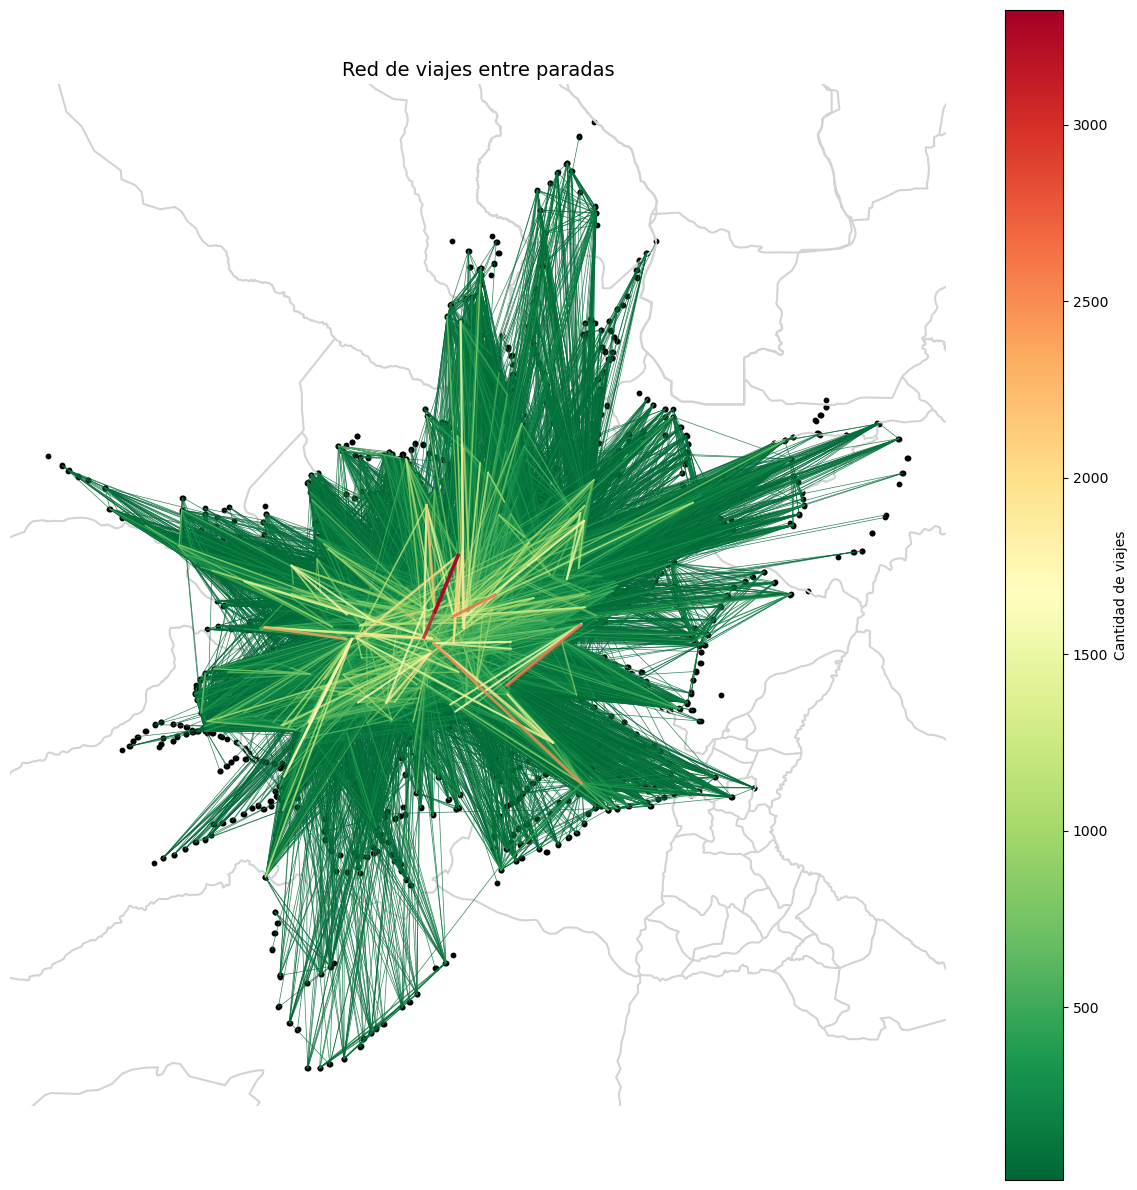

In [12]:
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# --- Cargar mapa base (si tienes uno) ---
try:
    zonas = gpd.read_file("mapa.gpkg")
except Exception as e:
    print(f"No se pudo cargar el archivo del mapa base: {e}")
    zonas = None

# --- Asumiendo que 'smart_inferidos' y 'stops_data' ya están definidos ---
# Si no lo están, asegúrate de cargarlos o crearlos antes de este punto.
# Por ejemplo:
# smart_inferidos = pd.read_csv('rutas_inferidas.csv')
# stops_data = pd.read_csv('datos_paradas.csv')


# 1. Agrupar viajes y filtrar
viajes = smart_inferidos[['Origen', 'Destino']].value_counts().reset_index(name='cantidad')
viajes = viajes[viajes['cantidad'] > 10]

# 2. Unir coordenadas
stops_orig = stops_data.rename(columns={'ID-PARADA': 'Origen', 'LONGITUD': 'LONG_ORIG', 'LATITUD': 'LAT_ORIG'})
stops_dest = stops_data.rename(columns={'ID-PARADA': 'Destino', 'LONGITUD': 'LONG_DEST', 'LATITUD': 'LAT_DEST'})
viajes = viajes.merge(stops_orig, on='Origen').merge(stops_dest, on='Destino')

# 3. Crear grafo no dirigido
G = nx.from_pandas_edgelist(viajes, 'Origen', 'Destino', edge_attr='cantidad', create_using=nx.Graph())

# 4. Posiciones
pos = {row['ID-PARADA']: (row['LONGITUD'], row['LATITUD']) for _, row in stops_data.iterrows()}
nx.set_node_attributes(G, pos, 'pos')

# --- Calcular límites para el zoom ---
all_longitudes = [p[0] for p in pos.values()]
all_latitudes = [p[1] for p in pos.values()]

min_lon, max_lon = min(all_longitudes), max(all_longitudes)
min_lat, max_lat = min(all_latitudes), max(all_latitudes)

margin = 0.01
xlim = (min_lon - margin, max_lon + margin)
ylim = (min_lat - margin, max_lat + margin)

# 5. Visualización
fig, ax = plt.subplots(figsize=(12, 12))

# --- Fondo opcional ---
if zonas is not None:
    zonas.plot(ax=ax, color='lightgray', edgecolor='gray')
else:
    print("Mapa base no disponible, se graficarán solo los puntos y líneas.")

# --- Dibujar nodos primero ---
xs, ys = zip(*pos.values())
ax.scatter(xs, ys, color='black', s=10, zorder=1)

# --- Preparar aristas: ordenadas por cantidad (menor a mayor) ---
edges = sorted(G.edges(data=True), key=lambda e: e[2]['cantidad'])
weights = [attr['cantidad'] for _, _, attr in edges]
norm = Normalize(vmin=min(weights), vmax=max(weights))
cmap = get_cmap('RdYlGn_r')

# --- Dibujar aristas luego, en orden creciente (para que las de mayor cantidad se superpongan) ---
for u, v, data in edges:
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    ax.plot(
        [x0, x1], [y0, y1],
        color=cmap(norm(data['cantidad'])),
        linewidth=0.5 + 2 * (data['cantidad'] / max(weights)),
        alpha=0.8,
        zorder=2
    )

# --- Colorbar ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax, label='Cantidad de viajes')

# --- Ajustar los límites del plot ---
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# --- Finalizar gráfica ---
ax.set_title('Red de viajes entre paradas', fontsize=14)
ax.axis('off')
plt.tight_layout()

# --- Guardar el gráfico (¡Nuevo!) ---
# Define el nombre del archivo y la ruta donde quieres guardarlo.
# Puedes elegir diferentes formatos como '.png', '.jpeg', '.svg', '.pdf', etc.
# 'dpi' (dots per inch) controla la resolución del archivo.
# 'bbox_inches='tight'' asegura que no haya bordes blancos excesivos.
plt.savefig('red_de_viajes.png', dpi=300, bbox_inches='tight')
print("Gráfico guardado como 'red_de_viajes.png'")

# --- Mostrar el gráfico (opcional, si quieres verlo después de guardarlo) ---
plt.show()

## Balance de Datos (OPCIONAL)

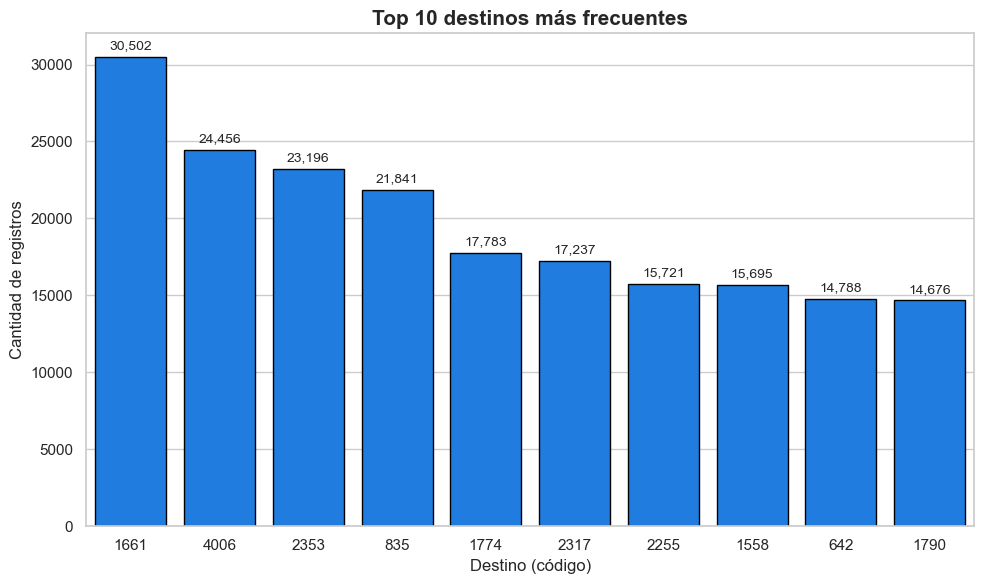

In [35]:
import seaborn as sns
# Asegurar que 'Destino' sea texto
smart_inferidos['Destino'] = smart_inferidos['Destino'].astype(str)

# Obtener top 10 destinos más frecuentes
top_destinos = smart_inferidos['Destino'].value_counts().head(10).reset_index()
top_destinos.columns = ['Destino', 'Conteo']

# Estilo
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Crear gráfico con un solo color
bar_color = '#007BFF'  # azul eléctrico

ax = sns.barplot(
    data=top_destinos,
    x='Destino',
    y='Conteo',
    color=bar_color,
    edgecolor='black'  # contorno negro
)

# Etiquetas
plt.xlabel("Destino (código)", fontsize=12)
plt.ylabel("Cantidad de registros", fontsize=12)
plt.title("Top 10 destinos más frecuentes", fontsize=15, weight='bold')

# Mostrar valores sobre las barras
for i, v in enumerate(top_destinos['Conteo']):
    ax.text(i, v + max(top_destinos['Conteo'])*0.01, f"{v:,}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


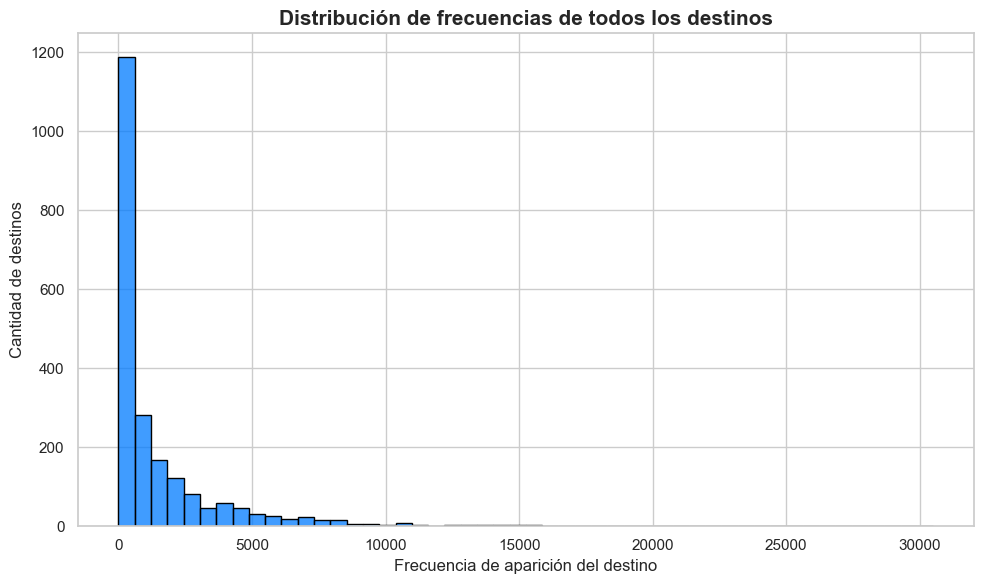

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar ocurrencias de cada destino
frecuencias = smart_inferidos['Destino'].value_counts()

# Estilo
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Histograma de la distribución de frecuencias
sns.histplot(frecuencias, bins=50, color="#007BFF", edgecolor="black")

plt.xlabel("Frecuencia de aparición del destino", fontsize=12)
plt.ylabel("Cantidad de destinos", fontsize=12)
plt.title("Distribución de frecuencias de todos los destinos", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()


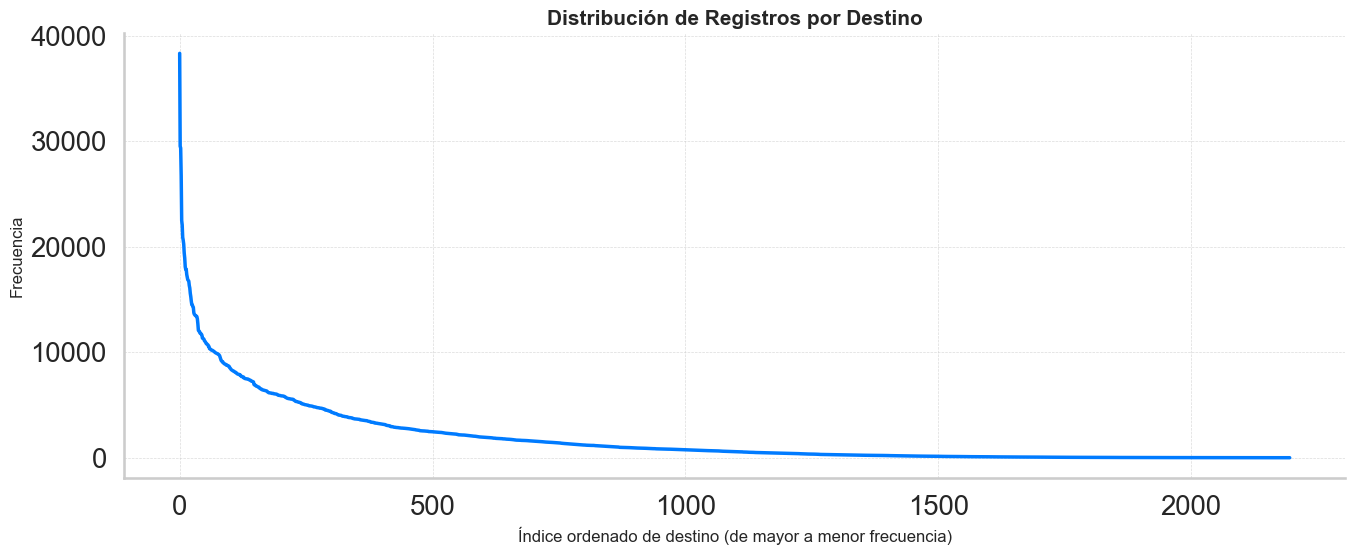

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener todas las frecuencias ordenadas de mayor a menor
frecuencias = smart_inferidos['Destino'].value_counts().sort_values(ascending=False).reset_index()
frecuencias.columns = ['Destino', 'Conteo']

# Estilo
sns.set(style="whitegrid", context = 'talk', font_scale = 1.2)
plt.figure(figsize=(14, 6))

# Gráfico de línea (tipo distribución ordenada)
plt.plot(frecuencias.index, frecuencias['Conteo'], color='#007BFF', linewidth=2.5,
        markerfacecolor='white', 
    markeredgecolor='black')
plt.xlabel("Índice ordenado de destino (de mayor a menor frecuencia)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
sns.despine()

plt.title("Distribución de Registros por Destino", fontsize=15, weight='bold')
plt.tight_layout()
plt.savefig("grafica_frecuencias_destino.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


<b> Eliminar Menos Frecuentes

In [24]:
import pandas as pd

# 1. Calcular frecuencia de cada parada y ordenar descendente
frecuencia_paradas = smart_inferidos['Destino'].value_counts().sort_values(ascending=False)
# 2. Calcular el porcentaje acumulado
frecuencia_paradas = frecuencia_paradas.to_frame(name='conteo')
frecuencia_paradas['porcentaje_acumulado'] = (frecuencia_paradas['conteo'].cumsum() / frecuencia_paradas['conteo'].sum()) * 100
# 3. Filtrar paradas hasta alcanzar el 80%
umbral_95 = frecuencia_paradas[frecuencia_paradas['porcentaje_acumulado'] <= 90]
paradas_top_95 = umbral_95.index.tolist()
# 4. Resultados clave
print(f"Total paradas únicas: {len(frecuencia_paradas)}")
print(f"Paradas que cubren el 90%: {len(paradas_top_95)}")
print(f"Reducción: {len(frecuencia_paradas) - len(paradas_top_95)} paradas eliminadas ({(1 - len(paradas_top_95)/len(frecuencia_paradas)):.1%} menos)")
# 5. (Opcional) Filtrar el DataFrame original
smart_inferidos_filtrado = smart_inferidos[smart_inferidos['Destino'].isin(paradas_top_95)].copy()


Total paradas únicas: 2117
Paradas que cubren el 90%: 777
Reducción: 1340 paradas eliminadas (63.3% menos)


<b> Agrupar Menos Frecuentes

In [7]:
len(smart_inferidos)

3203472

In [8]:
# 1. Calcular frecuencia de cada parada
frecuencia_paradas = smart_inferidos['Destino'].value_counts()

# 2. Identificar paradas frecuentes y poco frecuentes
umbral = 50
paradas_frecuentes = frecuencia_paradas[frecuencia_paradas >= umbral].index
paradas_poco_frecuentes = frecuencia_paradas[frecuencia_paradas < umbral].index

# 3. Reemplazar paradas poco frecuentes por "OTRAS"
smart_inferidos['Destino'] = smart_inferidos['Destino'].apply(
    lambda x: x if x in paradas_frecuentes else 'OTRAS'
)

# 4. Crear nuevo DataFrame con la columna 'Destino' ya filtrada
smart_inferidos_filtrado = smart_inferidos.copy()

# 5. Ver frecuencia actualizada
frecuencia_agrupada = smart_inferidos_filtrado['Destino'].value_counts()

# 6. Mostrar resultados clave
print(f"Paradas únicas antes: {len(frecuencia_paradas)}")
print(f"Paradas agrupadas como 'OTRAS': {len(paradas_poco_frecuentes)}")
print(f"Paradas únicas después: {smart_inferidos_filtrado['Destino'].nunique()}")
print(f"\nFrecuencia después del agrupamiento:\n{frecuencia_agrupada}")


Paradas únicas antes: 2196
Paradas agrupadas como 'OTRAS': 478
Paradas únicas después: 1719

Frecuencia después del agrupamiento:
Destino
1661    38330
2353    29527
4006    29354
835     26742
1774    22491
        ...  
280        51
408        51
3589       51
880        50
3453       50
Name: count, Length: 1719, dtype: int64


In [9]:
smart_inferidos = smart_inferidos_filtrado.copy()

In [18]:
#smart_inferidos[smart_inferidos['Destino']=='OTRAS']

<b> Codificacion de Columnas

In [7]:
smart_inferidos.columns

Index(['CodigoTarjeta', 'FechaHoraAscenso', 'Origen', 'LineaViaje', 'Destino',
       'total_pois', 'amenity_fast_food',
       'amenity_hospital_healthcare_hospital',
       'amenity_place_of_worship_religion_christian', 'amenity_restaurant',
       'amenity_school', 'landuse_industrial', 'landuse_residential',
       'tourism_hotel', 'recreation', 'public_utility', 'food_drink',
       'education', 'leisure_swimming_pool', 'amenity_cinema', 'amenity_bench',
       'CodigoZona', 'CodigoZonaAgrupado', 'CodigoZonaDestino'],
      dtype='object')

## Ingenieria de Caracteristicas

In [10]:
print(smart_inferidos['Hora'].value_counts().sort_index().to_markdown())

|   Hora |   count |
|-------:|--------:|
|      5 |    1889 |
|      6 |   42232 |
|      7 |   53991 |
|      8 |   56583 |
|      9 |   60533 |
|     10 |   70998 |
|     11 |   78477 |
|     12 |   95143 |
|     13 |   86950 |
|     14 |   74798 |
|     15 |   72503 |
|     16 |   75730 |
|     17 |   84138 |
|     18 |   73324 |
|     19 |   31198 |
|     20 |   11025 |
|     21 |    4512 |
|     22 |     160 |


In [11]:
conditions = [
    (smart_inferidos['Hora'].between(0, 4)),   # Muy bajo tráfico
    (smart_inferidos['Hora'].between(5, 6)),   # Hora pico mañana temprano
    (smart_inferidos['Hora'].between(7, 9)),   # Mañana activa
    (smart_inferidos['Hora'].between(10, 18)), # Día estable
    (smart_inferidos['Hora'].between(19, 21)), # Tarde-noche
    (smart_inferidos['Hora'] >= 22)            # Noche muy baja actividad
]

choices = ['Baja_Noche', 'Pico_Mañana_Temprano', 'Mañana_Activa', 
           'Dia_Estable', 'Tarde_Noche', 'Muy_Baja_Noche']

smart_inferidos['Grupo_Hora'] = np.select(conditions, choices)

## Preparacion de Variables

In [10]:
# Asegúrate de que las columnas sean datetime
smart_inferidos["FechaHoraAscenso"] = pd.to_datetime(smart_inferidos["FechaHoraAscenso"])
smart_inferidos["Hora"] = smart_inferidos["FechaHoraAscenso"].dt.hour

Codificar variables categoricas

In [12]:
smart_inferidos['Destino'] = smart_inferidos['Destino'].astype(str)
smart_inferidos['Origen'] = smart_inferidos['Origen'].astype(str)

In [13]:
le_tarjeta = LabelEncoder()
smart_inferidos["user_id"] = le_tarjeta.fit_transform(smart_inferidos["CodigoTarjeta"])
le_linea = LabelEncoder()
smart_inferidos["linea_id"] = le_linea.fit_transform(smart_inferidos["LineaViaje"])
le_parada = LabelEncoder()
smart_inferidos["parada_ascenso_id"] = le_parada.fit_transform(smart_inferidos["Origen"])
le_destino = LabelEncoder()
smart_inferidos["parada_descenso_id"] = le_destino.fit_transform(smart_inferidos["Destino"])
le_hora = LabelEncoder()
smart_inferidos["grupo_hora"] = le_hora.fit_transform(smart_inferidos["Grupo_Hora"])


In [14]:
le_zona = LabelEncoder()
smart_inferidos["zona_id"] = le_zona.fit_transform(smart_inferidos["CodigoZonaAgrupado"])

#le_zonades = LabelEncoder()
#smart_inferidos["zona_destino_id"] = le_zona.fit_transform(smart_inferidos["CodigoZonaDestino"])


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Lista de columnas proporcionales (excluye total_pois)
poi_cols = [
    'amenity_fast_food', 'amenity_hospital_healthcare_hospital',
    'amenity_place_of_worship_religion_christian', 'amenity_restaurant',
    'amenity_school', 'landuse_industrial', 'landuse_residential',
    'tourism_hotel', 'recreation', 'public_utility', 'food_drink',
    'education', 'leisure_swimming_pool', 'amenity_cinema', 'amenity_bench'
]

# Escalar total_pois (opcional pero recomendado)
scaler_total = MinMaxScaler()
smart_inferidos['total_pois_scaled'] = scaler_total.fit_transform(smart_inferidos[['total_pois']])

# POI vector como numpy array
poi_vector = smart_inferidos[poi_cols].to_numpy()


## Modelo Red Neuronal

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, BatchNormalization, Multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense  # Importación correcta

# Parámetros
n_users = smart_inferidos["user_id"].nunique()
n_lineas = smart_inferidos["linea_id"].nunique()
n_paradas = smart_inferidos["parada_ascenso_id"].nunique()
n_destinos = smart_inferidos['parada_descenso_id'].nunique()
n_zonas = smart_inferidos["zona_id"].nunique()
n_poi_cols = 15

# Entradas
user_input = Input(shape=(1,), name='user_id')
linea_input = Input(shape=(1,), name='linea_id')
parada_input = Input(shape=(1,), name='parada_ascenso_id')
hora_input = Input(shape=(1,), name='grupo_hora')
total_pois_input = Input(shape=(1,), name='total_pois')
poi_vector_input = Input(shape=(n_poi_cols,), name='poi_vector')
zona_origen_input = Input(shape=(1,), name='zona_id')


# Embeddings
user_emb = Flatten()(Embedding(input_dim=n_users, output_dim=32)(user_input))
linea_emb = Flatten()(Embedding(input_dim=n_lineas, output_dim=16)(linea_input))
parada_emb = Flatten()(Embedding(input_dim=n_paradas, output_dim=16)(parada_input))
zona_emb = Flatten()(Embedding(input_dim=n_zonas, output_dim=8)(zona_origen_input))
# Concatenar
x = Concatenate()([user_emb, linea_emb, hora_input, total_pois_input, poi_vector_input, parada_emb, zona_emb])
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
# Mecanismo de atención
#attention = Dense(256, activation='sigmoid')(x)
#x = Multiply()([x, attention])
output = Dense(n_destinos, activation='softmax')(x)
model = Model(inputs=[user_input, linea_input, hora_input, total_pois_input, poi_vector_input, parada_input, zona_origen_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_id (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ linea_id (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ parada_ascenso_id             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zona_id (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 32)             │      11,312,960 │ user_id[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 16)             │           1,328 │ linea_id[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 1, 16)             │          34,544 │ parada_ascenso_id[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 1, 8)              │             264 │ zona_id[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 32)                │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 16)                │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ grupo_hora (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ total_pois (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ poi_vector (InputLayer)       │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 16)                │               0 │ embedding_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_3 (Flatten)           │ (None, 8)                 │               0 │ embedding_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 89)                │               0 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0],           │
│                               │                           │               

 Total params: 11,626,783 (44.35 MB)

 Trainable params: 11,626,783 (44.35 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.utils import class_weight
import tensorflow as tf


In [18]:
def sparse_top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1]), y_pred, k=5)

In [49]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Inputs y etiquetas
X = smart_inferidos
y = smart_inferidos["parada_descenso_id"].values

# K-Fold con 5 divisiones estratificadas
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔁 Fold {fold + 1}")
    
    # Separar en entrenamiento y validación
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Entradas por separado
    inputs_train = {
        "user_id": X_train["user_id"],
        "linea_id": X_train["linea_id"],
        "parada_ascenso_id": X_train["parada_ascenso_id"],
        "zona_id": X_train['zona_id'],
        "grupo_hora": X_train["grupo_hora"],
        "total_pois": X_train["total_pois_scaled"],
        "poi_vector": X_train[poi_cols].to_numpy()
    }

    inputs_val = {
        "user_id": X_val["user_id"],
        "linea_id": X_val["linea_id"],
        "parada_ascenso_id": X_val['parada_ascenso_id'],
        "zona_id": X_val["zona_id"],
        "grupo_hora": X_val["grupo_hora"],
        "total_pois": X_val["total_pois_scaled"],
        "poi_vector": X_val[poi_cols].to_numpy()
    }

    # Modelo nuevo para cada fold
    model_fold = tf.keras.models.clone_model(model)
    model_fold.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy', sparse_top_5_accuracy])

    # Entrenamiento
    model_fold.fit(inputs_train, y_train, epochs=15, batch_size=2048,
                   validation_data=(inputs_val, y_val), verbose=1)



🔁 Fold 1
Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.0579 - loss: 5.1664 - sparse_top_5_accuracy: 0.1884 - val_accuracy: 0.1531 - val_loss: 3.8341 - val_sparse_top_5_accuracy: 0.4497
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.1967 - loss: 3.5911 - sparse_top_5_accuracy: 0.5016 - val_accuracy: 0.2257 - val_loss: 3.5732 - val_sparse_top_5_accuracy: 0.5093
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.3932 - loss: 2.7057 - sparse_top_5_accuracy: 0.6802 - val_accuracy: 0.2713 - val_loss: 3.5868 - val_sparse_top_5_accuracy: 0.5231
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5409 - loss: 2.0354 - sparse_top_5_accuracy: 0.7872 - val_accuracy: 0.2908 - val_loss: 3.7430 - val_sparse_top_5_accuracy: 0.5248
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.6167 - loss: 1.6305 - sparse_top_5_accuracy: 0.8436 - val_accuracy: 0.3001 - val_loss: 3.8986 - val_sparse_top_5_accuracy: 0.5267


#### Metricas Adicionales

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Inputs y etiquetas
X = smart_inferidos
y = smart_inferidos["parada_descenso_id"].values

# K-Fold con 5 divisiones estratificadas
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métrica personalizada top-5 para Keras
def sparse_top_5_accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔁 Fold {fold + 1}")
    
    # Separar en entrenamiento y validación
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Entradas por separado
    inputs_train = {
        "user_id": X_train["user_id"],
        "linea_id": X_train["linea_id"],
        "parada_ascenso_id": X_train["parada_ascenso_id"],
        "zona_id": X_train['zona_id'],
        "grupo_hora": X_train["grupo_hora"],
        "total_pois": X_train["total_pois_scaled"],
        "poi_vector": X_train[poi_cols].to_numpy()
    }

    inputs_val = {
        "user_id": X_val["user_id"],
        "linea_id": X_val["linea_id"],
        "parada_ascenso_id": X_val['parada_ascenso_id'],
        "zona_id": X_val["zona_id"],
        "grupo_hora": X_val["grupo_hora"],
        "total_pois": X_val["total_pois_scaled"],
        "poi_vector": X_val[poi_cols].to_numpy()
    }

    # Modelo nuevo para cada fold
    model_fold = tf.keras.models.clone_model(model)
    model_fold.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy',
                       metrics=['accuracy', sparse_top_5_accuracy])

    # Entrenamiento
    model_fold.fit(inputs_train, y_train, epochs=15, batch_size=2048,
                   validation_data=(inputs_val, y_val), verbose=1)
    
    # Predicciones
    y_pred_probs = model_fold.predict(inputs_val)
    y_pred_top1 = np.argmax(y_pred_probs, axis=1)

    # Evaluación
    print("\n📊 Clasification Report (Top-1):")
    print(classification_report(y_val, y_pred_top1, zero_division=0))

    # Top-5 accuracy con sklearn
    top5 = top_k_accuracy_score(y_val, y_pred_probs, k=5)
    print(f"✅ Top-5 Accuracy (sklearn): {top5:.4f}")
    
    # Opcional: matriz de confusión (comentar si muchas clases)
    # print(confusion_matrix(y_val, y_pred_top1))



🔁 Fold 1
Epoch 1/15
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 0.0946 - loss: 5.1882 - sparse_top_5_accuracy: 0.1956 - val_accuracy: 0.2717 - val_loss: 3.6895 - val_sparse_top_5_accuracy: 0.4322
Epoch 2/15
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 158s 88ms/step - accuracy: 0.3354 - loss: 3.2877 - sparse_top_5_accuracy: 0.5059 - val_accuracy: 0.3641 - val_loss: 3.2472 - val_sparse_top_5_accuracy: 0.5268
Epoch 3/15
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 157s 87ms/step - accuracy: 0.4375 - loss: 2.7054 - sparse_top_5_accuracy: 0.6157 - val_accuracy: 0.3995 - val_loss: 3.0860 - val_sparse_top_5_accuracy: 0.5646
Epoch 4/15
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 158s 88ms/step - accuracy: 0.4891 - loss: 2.3774 - sparse_top_5_accuracy: 0.6735 - val_accuracy: 0.4135 - val_loss: 3.0320 - val_sparse_top_5_accuracy: 0.5812
Epoch 5/15
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 160s 89ms/step - accuracy: 0.5185 - loss: 2.1651 - sparse_top_5_accuracy: 0.7096 - val_accuracy: 0.4206 - val_loss: 3.0223 - val_sparse_top_5_ac

In [108]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Dataset original
df = smart_inferidos.copy()

# Agrupar y contar destinos por origen
frecuencias = (
    df.groupby(['parada_ascenso_id', 'parada_descenso_id'])
    .size()
    .reset_index(name='frecuencia')
    .sort_values(['parada_ascenso_id', 'frecuencia'], ascending=[True, False])
)

# Obtener el modo por zona_id (predicción más frecuente)
modo_por_zona = (
    frecuencias.groupby('parada_ascenso_id')
    .first()  # primera fila por zona_id = mayor frecuencia
    .reset_index()
    .rename(columns={'parada_descenso_id': 'pred_modo'})
)
# Unir la predicción al dataframe original
df_pred_modo = df.merge(modo_por_zona, on='parada_ascenso_id', how='left')

# Calcular accuracy del baseline modo
acc_modo = accuracy_score(df_pred_modo['parada_descenso_id'], df_pred_modo['pred_modo'])
print(f"📌 Accuracy del método modo: {acc_modo:.4f}")


📌 Accuracy del método modo: 0.0834


## LightGBM

In [87]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Asegúrate de tener cargado el DataFrame
df = smart_inferidos.copy()

# Convertir columnas categóricas
df['CodigoZonaAgrupado'] = df['CodigoZonaAgrupado'].astype(str)
df['LineaViaje'] = df['LineaViaje'].astype(str)
df['CodigoZonaDestino'] = df['CodigoZonaDestino'].astype(str)

# Variables categóricas
cat_features = ['CodigoZonaAgrupado', 'LineaViaje']

# Variables numéricas (POIs + total_pois)
poi_columns = [
    'total_pois', 'amenity_fast_food',
    'amenity_hospital_healthcare_hospital',
    'amenity_place_of_worship_religion_christian', 'amenity_restaurant',
    'amenity_school', 'landuse_industrial', 'landuse_residential',
    'tourism_hotel', 'recreation', 'public_utility', 'food_drink',
    'education', 'leisure_swimming_pool', 'amenity_cinema', 'amenity_bench'
]

# Variable objetivo
target = 'CodigoZonaDestino'

# Variables independientes
features = cat_features + poi_columns


In [88]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target],
    test_size=0.2, random_state=42, stratify=df[target]
)

# Modelo
model = CatBoostClassifier(
    iterations=200,
    depth=4,
    learning_rate=0.1,
    loss_function='MultiClass',
    task_type='CPU',
    grow_policy='Lossguide',
    verbose=50
)

# Entrenar
model.fit(X_train, y_train, cat_features=cat_features)


0:	learn: 3.2786594	total: 31.8s	remaining: 1h 45m 19s
50:	learn: 2.2266450	total: 22m 38s	remaining: 1h 6m 10s


KeyboardInterrupt: 

<b> Instancia Reducida

In [89]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- Paso 1: Preparar datos de entrada ---

df = smart_inferidos.copy()

# Convertir columnas categóricas a string
df['CodigoZonaAgrupado'] = df['CodigoZonaAgrupado'].astype(str)
df['LineaViaje'] = df['LineaViaje'].astype(str)
df['CodigoZonaDestino'] = df['CodigoZonaDestino'].astype(str)

# Convertir columnas numéricas a float32 para ahorrar memoria
poi_columns = [
    'total_pois', 'amenity_fast_food',
    'amenity_hospital_healthcare_hospital',
    'amenity_place_of_worship_religion_christian', 'amenity_restaurant',
    'amenity_school', 'landuse_industrial', 'landuse_residential',
    'tourism_hotel', 'recreation', 'public_utility', 'food_drink',
    'education', 'leisure_swimming_pool', 'amenity_cinema', 'amenity_bench'
]
for col in poi_columns:
    df[col] = df[col].astype('float32')

# --- Paso 2: Muestreo reducido (200,000 filas) manteniendo distribución por clase ---

# Tomar muestra representativa

df_sample = df.sample(n=5_000, random_state=42)

# Variables
cat_features = ['CodigoZonaAgrupado', 'LineaViaje']
features = cat_features + poi_columns
target = 'CodigoZonaDestino'

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    df_sample[features],
    df_sample[target],
    test_size=0.2,
    random_state=42,
    stratify=df_sample[target]
)

# --- Paso 3: Entrenar modelo CatBoost simplificado ---

model = CatBoostClassifier(
    iterations=150,
    learning_rate=0.1,
    depth=4,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    verbose=50
)

model.fit(X_train, y_train, cat_features=cat_features)

# --- Paso 4: Evaluación ---

y_pred = model.predict(X_test)
print(classification_report(
    y_test.astype('category').cat.codes,
    pd.Series(y_pred.flatten()).astype('category').cat.codes
))


0:	learn: 3.3176038	total: 72.3ms	remaining: 10.8s
50:	learn: 2.3983170	total: 4.37s	remaining: 8.48s
100:	learn: 2.2682795	total: 8.25s	remaining: 4s
149:	learn: 2.2004525	total: 11.9s	remaining: 0us
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         5
           9       0.06      1.00      0.11         3
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        28
          12       0.01      0.07      0.02        14
          13       0.00      0.00      0.0

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
